In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from torch.utils.data import Dataset
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path_low, path_high, file_list):
        self.lr_path = path_low
        self.hr_path = path_high
        self.file_list = file_list
        self.target_size = (256, 256)  # Adjust this size as needed


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name_lr = os.path.join(self.lr_path, self.file_list[idx])
        img_name_hr = os.path.join(self.hr_path, re.sub(r'LR', 'HR', self.file_list[idx]))

        # Load LR and HR images
        image_lr = io.imread(img_name_lr, as_gray=True)
        image_hr = io.imread(img_name_hr, as_gray=True)

        # Resize images to a common size
        image_lr = transform.resize(image_lr, self.target_size, mode='constant', anti_aliasing=True)
        image_hr = transform.resize(image_hr, self.target_size, mode='constant', anti_aliasing=True)

        # Convert to PyTorch tensors
        image_lr = torch.from_numpy(image_lr).unsqueeze(0).float()
        image_hr = torch.from_numpy(image_hr).unsqueeze(0).float()

        return image_lr, image_hr


In [ ]:
path_low = "/content/drive/MyDrive/URBAN_CUSTOM_DATASET/Low Resolution"
path_high = "/content/drive/MyDrive/URBAN_CUSTOM_DATASET/High Resolution"

In [ ]:
file_list = [f for f in os.listdir(path_low) if f.endswith("LR.png")]

# Perform train-test split
train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)

# Create datasets and data loaders for train and test sets
train_dataset = CustomDataset(path_low, path_high, train_files)
test_dataset = CustomDataset(path_low, path_high, test_files)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

Defining the model

In [ ]:
#Defining the model

class VDSR_model(nn.Module):
    def __init__(self) -> None:
        super(VDSR_model, self).__init__()
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)  # Adjusted number of input channels to 1
        self.conv_2_to_19 = nn.Sequential()
        for i in range(2, 20):
            self.conv_2_to_19.add_module(f"conv_{i}", nn.Conv2d(64, 64, 3, padding=1))
            self.conv_2_to_19.add_module(f"relu_{i}", nn.ReLU())
        self.conv_20 = nn.Conv2d(64, 3, 3, padding=1)

        self.init_weights()

    def forward(self, X_in):
        x_in = X_in.clone()
        x = self.conv_1(X_in)
        torch.relu_(x)
        x = self.conv_2_to_19(x)
        x = self.conv_20(x)
        x = torch.add(x, x_in)
        x = torch.clip(x, 0.0, 1.0)
        return x

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VDSR_model().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10

for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs_lr, targets_hr in train_loader:
            optimizer.zero_grad()
            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)

            # Forward pass
            outputs_hr = model(inputs_lr).to(device)

            # Calculate the loss
            loss = criterion(outputs_hr, targets_hr)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Print the average loss for the epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 256, 256])) that is different to the input size (torch.Size([8, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Training Loss: 0.014452010841341689
Epoch 2/10, Training Loss: 0.0013596889446489512
Epoch 3/10, Training Loss: 0.0012112757016438992
Epoch 4/10, Training Loss: 0.0011709815997164696
Epoch 5/10, Training Loss: 0.001149863249156624
Epoch 6/10, Training Loss: 0.0011355967173585669
Epoch 7/10, Training Loss: 0.0011247942020418122
Epoch 8/10, Training Loss: 0.0011159871210111305
Epoch 9/10, Training Loss: 0.0011090952990343793
Epoch 10/10, Training Loss: 0.001103093835990876


In [ ]:
from torchsummary import summary


input_height, input_width = 256, 256

# Move the model to the device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (1, input_height, input_width))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,928
              ReLU-7         [-1, 64, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          36,928
              ReLU-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 256, 256]          36,928
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
           Conv2d-14         [-1, 64, 2

In [ ]:
!pip3 install torchviz graphviz

import torch
from torchviz import make_dot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create a dummy input tensor for visualization
dummy_input = torch.randn(1, 1, input_height, input_width).to(device)

# Visualize the model
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.render("srcnn_model", format="png", cleanup=True)

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=cc9bf8719b058b7b4d3dc7a60bb1941a59fc756a8dac83f661c024016b0ae976
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'srcnn_model.png'

In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs_lr, targets_hr in test_loader:
        outputs_hr = model(inputs_lr.to(device))
        test_loss += criterion(outputs_hr.to(device), targets_hr.to(device)).item()

average_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 256, 256])) that is different to the input size (torch.Size([8, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# Save the model parameters and weights
torch.save(model.state_dict(), 'VDSR.pth')

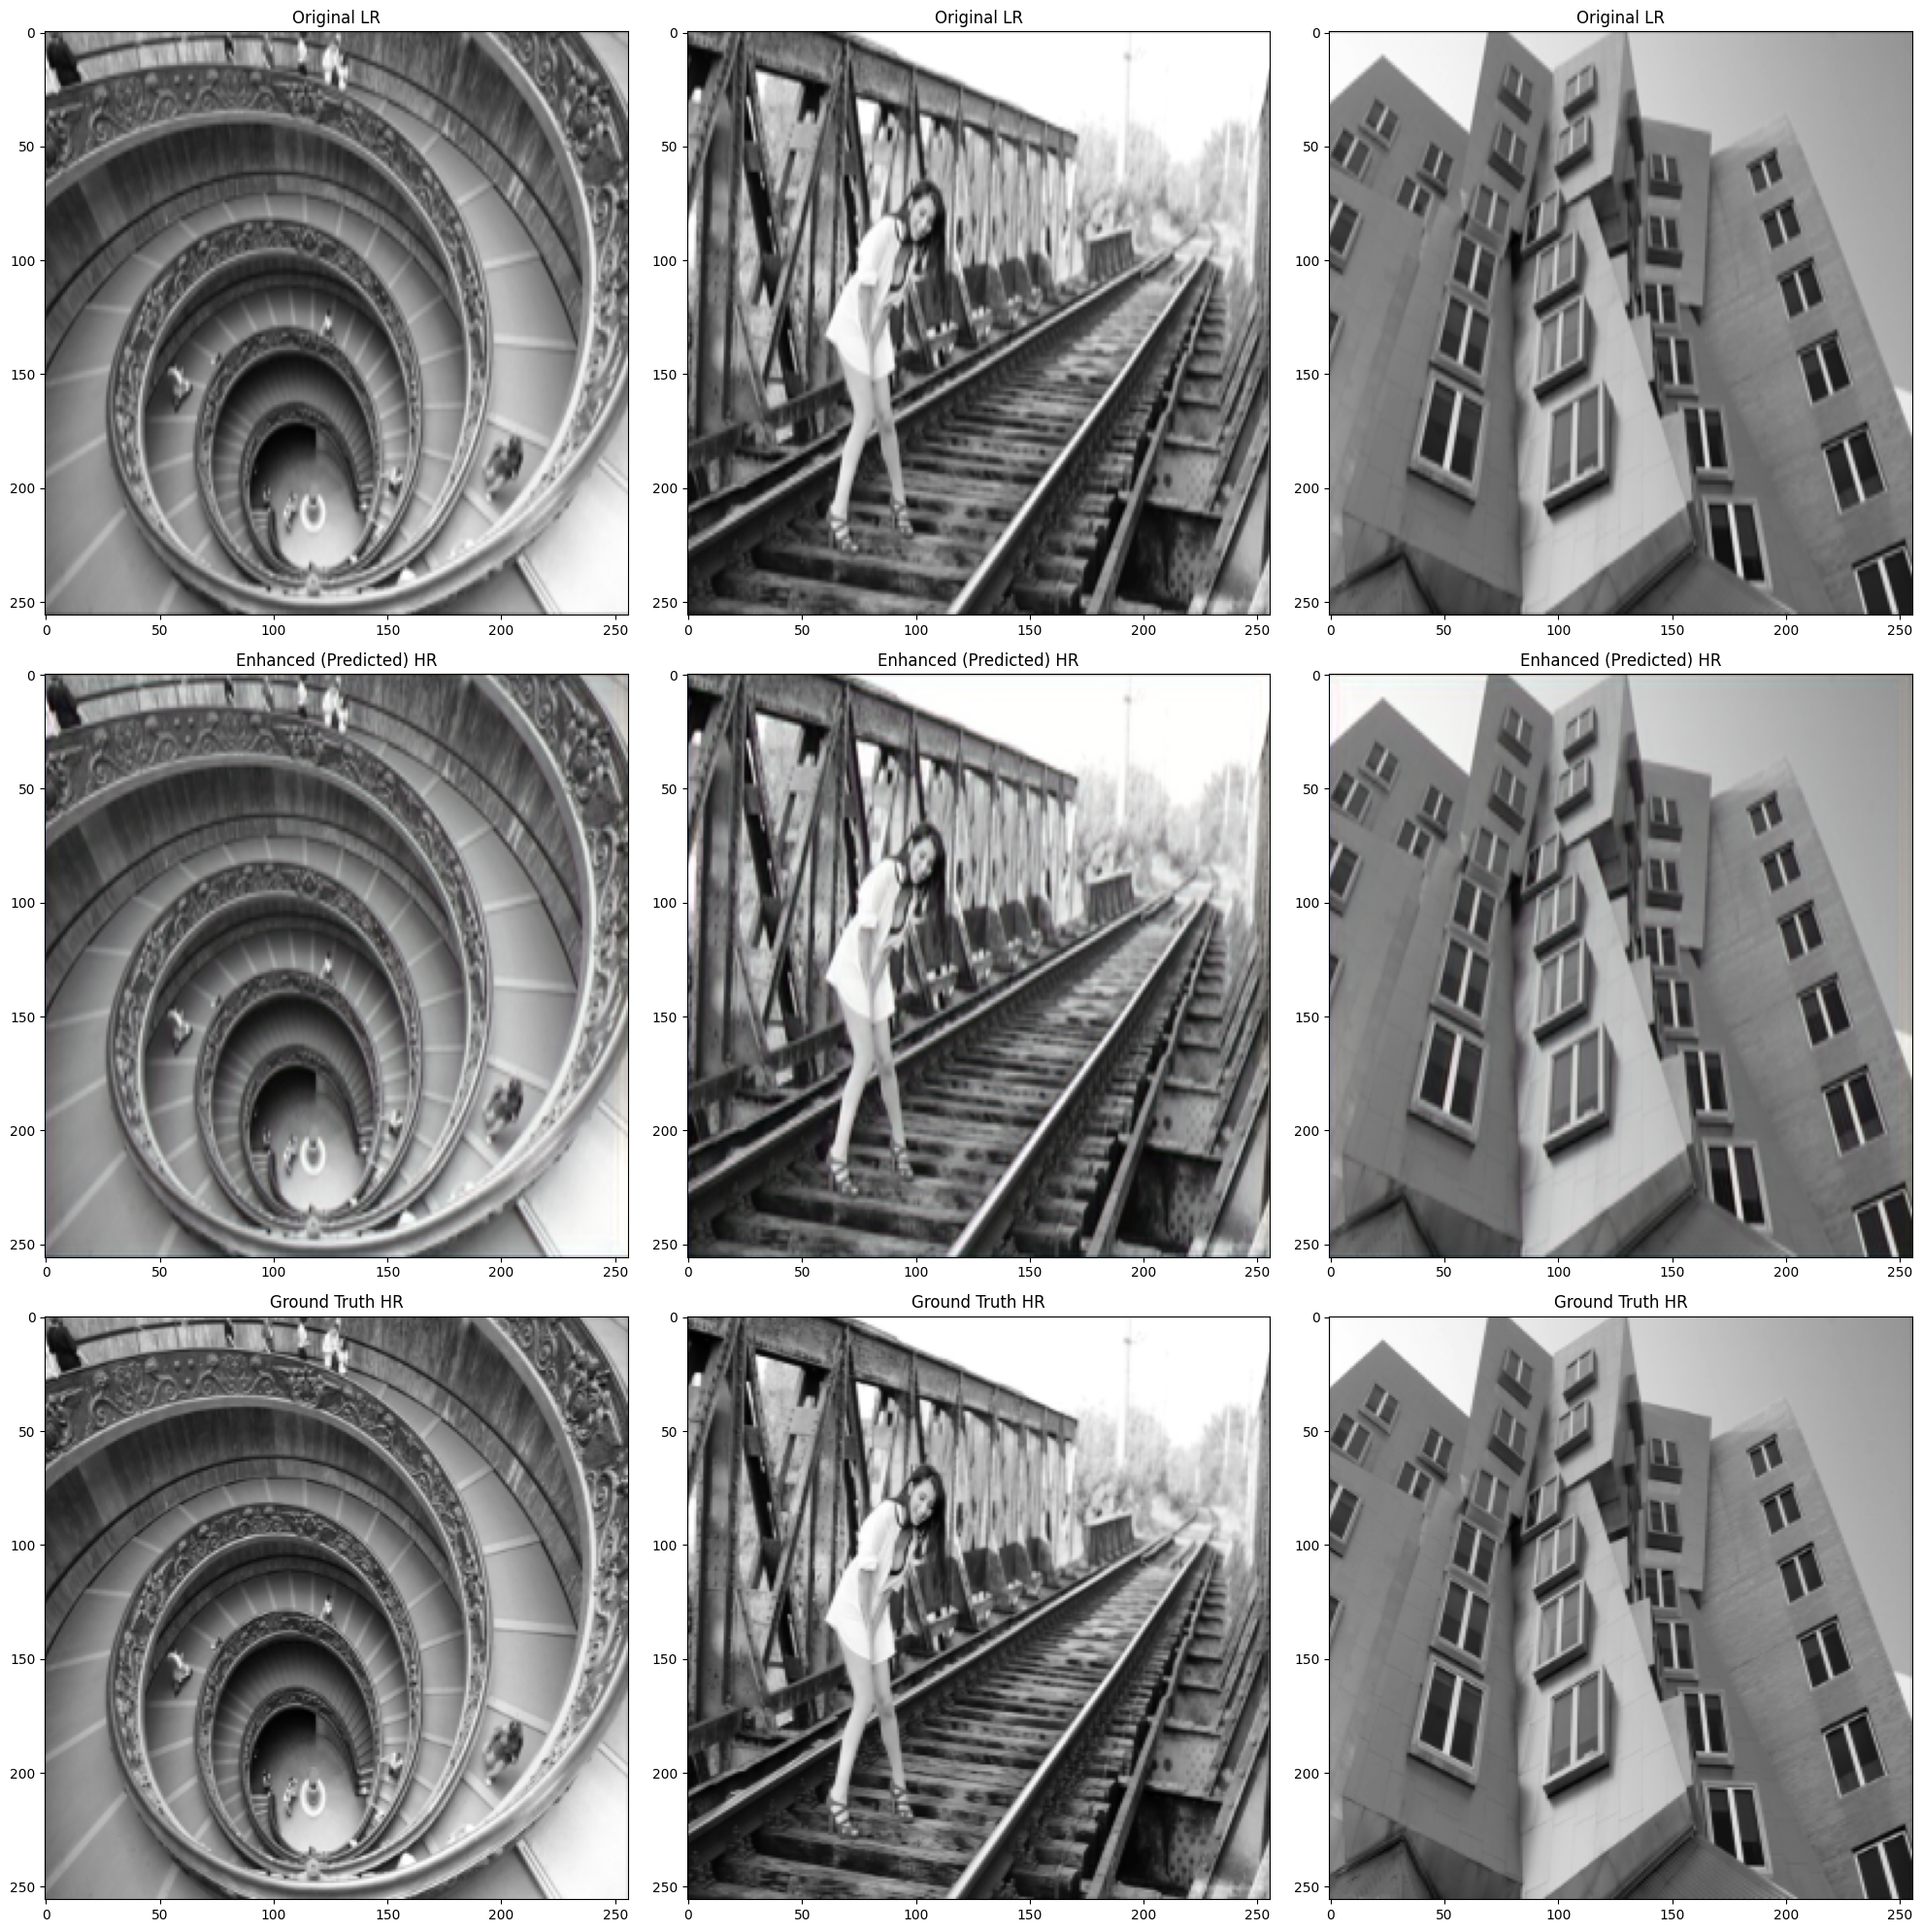

In [18]:
import matplotlib.pyplot as plt


model.eval()

# Visualize a few samples
num_samples_to_visualize = 3
plt.figure(figsize=(20,20))

for i, (inputs_lr, targets_hr) in enumerate(test_loader):
    if i == num_samples_to_visualize:
        break

    # Select the first image from the batch
    input_lr = inputs_lr[0]
    target_hr = targets_hr[0]

    # Forward pass to get the enhanced image
    output_hr = model(input_lr.to(device).unsqueeze(0))

    # Convert PyTorch tensors to NumPy arrays for visualization
    input_lr_np = input_lr.squeeze().cpu().numpy()
    output_hr_np = output_hr.squeeze().detach().cpu()
    target_hr_np = target_hr.squeeze().cpu().numpy()

    # Plot the original low-resolution image
    plt.subplot(3, num_samples_to_visualize, i + 1)
    plt.imshow(input_lr_np,cmap='gray')
    plt.title('Original LR')
    # Plot the enhanced image
    plt.subplot(3, num_samples_to_visualize, i + 1 + num_samples_to_visualize)
    output_hr_np = output_hr_np.permute(1, 2, 0)
    output_hr_np = output_hr_np.numpy()
    plt.imshow(output_hr_np,cmap='gray')
    plt.title('Enhanced (Predicted) HR')

    # Plot the ground truth high-resolution image
    plt.subplot(3, num_samples_to_visualize, i + 1 + 2 * num_samples_to_visualize)
    plt.imshow(target_hr_np,cmap='gray')
    plt.title('Ground Truth HR')

plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('image_grid.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import math

def psnr(img1, img2):
    mse = torch.mean((img1.to(device) - img2.to(device)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse.item()))
    return psnr


model.eval()

# Calculate PSNR for all test images
psnr_values = []

for i, (inputs_lr, targets_hr) in enumerate(test_loader):
    # Forward pass to get the enhanced image
    outputs_hr = model(inputs_lr.to(device)).to(device)

    # Calculate PSNR for each image in the batch
    for j in range(outputs_hr.size(0)):
        psnr_value = psnr(outputs_hr[j].to(device).squeeze(), targets_hr[j])
        psnr_values.append(psnr_value)

        print(f'Sample {i * test_loader.batch_size + j + 1}, PSNR: {psnr_value:.2f}')

# Calculate average PSNR
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.2f}')


Sample 1, PSNR: 30.81
Sample 2, PSNR: 27.56
Sample 3, PSNR: 31.31
Sample 4, PSNR: 26.17
Sample 5, PSNR: 28.15
Sample 6, PSNR: 25.70
Sample 7, PSNR: 34.12
Sample 8, PSNR: 35.80
Sample 9, PSNR: 31.43
Sample 10, PSNR: 29.51
Sample 11, PSNR: 30.49
Sample 12, PSNR: 28.02
Sample 13, PSNR: 30.13
Sample 14, PSNR: 26.97
Sample 15, PSNR: 35.51
Sample 16, PSNR: 32.47
Sample 17, PSNR: 33.96
Sample 18, PSNR: 29.89
Sample 19, PSNR: 30.67
Sample 20, PSNR: 24.59
Sample 21, PSNR: 30.11
Sample 22, PSNR: 23.87
Sample 23, PSNR: 29.12
Sample 24, PSNR: 39.54
Sample 25, PSNR: 31.88
Sample 26, PSNR: 32.54
Sample 27, PSNR: 33.33
Sample 28, PSNR: 33.35
Sample 29, PSNR: 27.45
Sample 30, PSNR: 33.30
Sample 31, PSNR: 29.71
Sample 32, PSNR: 28.61
Sample 33, PSNR: 29.56
Sample 34, PSNR: 32.32
Sample 35, PSNR: 26.43
Sample 36, PSNR: 37.49
Sample 37, PSNR: 33.29
Sample 38, PSNR: 29.03
Sample 39, PSNR: 31.36
Sample 40, PSNR: 33.34
Average PSNR: 30.72


In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np


# Set the model to evaluation mode
model.eval()

# Calculate SSIM for all test images
ssim_values = []

for i, (inputs_lr, targets_hr) in enumerate(test_loader):
    # Forward pass to get the enhanced image
    outputs_hr = model(inputs_lr.to(device))

    # Calculate SSIM for each image in the batch
    for j in range(outputs_hr.size(0)):
        # Convert tensors to numpy arrays
        output_hr_np = outputs_hr[j].squeeze().detach().cpu().numpy()[0]
        target_hr_np = targets_hr[j].squeeze().cpu().numpy()

        # Normalize images to the range [0, 255] if needed
        output_hr_np = (output_hr_np * 255).astype(np.uint8)
        target_hr_np = (target_hr_np * 255).astype(np.uint8)
        # Calculate SSIM
        ssim_value, _ = compare_ssim(output_hr_np, target_hr_np, full=True)
        ssim_values.append(ssim_value)

        print(f'Sample {i * test_loader.batch_size + j + 1}, SSIM: {ssim_value:.4f}')

# Calculate average SSIM
average_ssim = sum(ssim_values) / len(ssim_values)
print(f'Average SSIM: {average_ssim:.4f}')


Sample 1, SSIM: 0.9604
Sample 2, SSIM: 0.9505
Sample 3, SSIM: 0.9674
Sample 4, SSIM: 0.9079
Sample 5, SSIM: 0.8960
Sample 6, SSIM: 0.8981
Sample 7, SSIM: 0.9725
Sample 8, SSIM: 0.9733
Sample 9, SSIM: 0.9728
Sample 10, SSIM: 0.9610
Sample 11, SSIM: 0.9670
Sample 12, SSIM: 0.9012
Sample 13, SSIM: 0.9404
Sample 14, SSIM: 0.8533
Sample 15, SSIM: 0.9869
Sample 16, SSIM: 0.9717
Sample 17, SSIM: 0.9710
Sample 18, SSIM: 0.9624
Sample 19, SSIM: 0.9681
Sample 20, SSIM: 0.9048
Sample 21, SSIM: 0.9421
Sample 22, SSIM: 0.9000
Sample 23, SSIM: 0.9298
Sample 24, SSIM: 0.9935
Sample 25, SSIM: 0.9666
Sample 26, SSIM: 0.9197
Sample 27, SSIM: 0.9793
Sample 28, SSIM: 0.9864
Sample 29, SSIM: 0.9139
Sample 30, SSIM: 0.9656
Sample 31, SSIM: 0.9712
Sample 32, SSIM: 0.9455
Sample 33, SSIM: 0.9409
Sample 34, SSIM: 0.9688
Sample 35, SSIM: 0.9660
Sample 36, SSIM: 0.9906
Sample 37, SSIM: 0.9799
Sample 38, SSIM: 0.9593
Sample 39, SSIM: 0.9849
Sample 40, SSIM: 0.9714
Average SSIM: 0.9515


In [ ]:
import torch
import math

def rmse(img1, img2):
    mse = torch.mean((img1.to(device) - img2.to(device)) ** 2)
    rmse_value = math.sqrt(mse.item())
    return rmse_value

model.eval()

# Calculate RMSE for all test images
rmse_values = []

for i, (inputs_lr, targets_hr) in enumerate(test_loader):
    # Forward pass to get the enhanced image
    outputs_hr = model(inputs_lr.to(device))

    # Calculate RMSE for each image in the batch
    for j in range(outputs_hr.size(0)):
        rmse_value = rmse(outputs_hr[j].squeeze(), targets_hr[j])
        rmse_values.append(rmse_value)

        print(f'Sample {i * test_loader.batch_size + j + 1}, RMSE: {rmse_value:.2f}')

# Calculate average RMSE
average_rmse = sum(rmse_values) / len(rmse_values)
print(f'Average RMSE: {average_rmse:.2f}')


Sample 1, RMSE: 0.03
Sample 2, RMSE: 0.04
Sample 3, RMSE: 0.03
Sample 4, RMSE: 0.05
Sample 5, RMSE: 0.04
Sample 6, RMSE: 0.05
Sample 7, RMSE: 0.02
Sample 8, RMSE: 0.02
Sample 9, RMSE: 0.03
Sample 10, RMSE: 0.03
Sample 11, RMSE: 0.03
Sample 12, RMSE: 0.04
Sample 13, RMSE: 0.03
Sample 14, RMSE: 0.04
Sample 15, RMSE: 0.02
Sample 16, RMSE: 0.02
Sample 17, RMSE: 0.02
Sample 18, RMSE: 0.03
Sample 19, RMSE: 0.03
Sample 20, RMSE: 0.06
Sample 21, RMSE: 0.03
Sample 22, RMSE: 0.06
Sample 23, RMSE: 0.04
Sample 24, RMSE: 0.01
Sample 25, RMSE: 0.03
Sample 26, RMSE: 0.02
Sample 27, RMSE: 0.02
Sample 28, RMSE: 0.02
Sample 29, RMSE: 0.04
Sample 30, RMSE: 0.02
Sample 31, RMSE: 0.03
Sample 32, RMSE: 0.04
Sample 33, RMSE: 0.03
Sample 34, RMSE: 0.02
Sample 35, RMSE: 0.05
Sample 36, RMSE: 0.01
Sample 37, RMSE: 0.02
Sample 38, RMSE: 0.04
Sample 39, RMSE: 0.03
Sample 40, RMSE: 0.02
Average RMSE: 0.03
